# Import package & load dataset

In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import math
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load dataset

drive.mount('/content/drive')
path = '/content/drive/MyDrive/DAC K34/Machine Learning/Final project/churn_prediction.xlsx'

df = pd.read_excel(path)

Mounted at /content/drive


In [ ]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,52869,0,20.0,Mobile Phone,3,7.0,E wallet,Female,4.0,4,Fashion,5,Married,3,0,26.0,5.0,16.0,NaN,229.53
1,52942,0,13.0,Computer,1,9.0,Cash on Delivery,Female,4.0,4,Fashion,3,Single,2,0,26.0,11.0,NaN,9.0,234.38
2,52972,0,16.0,Mobile Phone,3,7.0,Debit Card,Male,3.0,4,Laptop & Accessory,3,Divorced,3,0,26.0,5.0,12.0,7.0,174.07
3,53125,0,5.0,Mobile Phone,1,16.0,Debit Card,Male,3.0,4,Fashion,4,Married,3,0,26.0,2.0,2.0,9.0,231.48
4,53367,0,9.0,Mobile Phone,1,28.0,Debit Card,Female,3.0,4,Laptop & Accessory,2,Divorced,3,1,26.0,1.0,2.0,8.0,165.14


# Data cleaning

## 1. Data overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [ ]:
df.shape

(5630, 20)

## 2. Duplicates + Missing values

In [ ]:
# kiểm tra unique values
## in ra tỉ lệ % của unique values
num_unique = df.nunique().sort_values()
print('---Percentage of unique values (%)---')
print(100/num_unique)

---Percentage of unique values (%)---
Churn                          50.000000
Gender                         50.000000
Complain                       50.000000
CityTier                       33.333333
MaritalStatus                  33.333333
PreferredLoginDevice           33.333333
SatisfactionScore              20.000000
HourSpendOnApp                 16.666667
PreferedOrderCat               16.666667
NumberOfDeviceRegistered       16.666667
PreferredPaymentMode           14.285714
NumberOfAddress                 6.666667
OrderAmountHikeFromlastYear     6.250000
OrderCount                      6.250000
CouponUsed                      5.882353
DaySinceLastOrder               4.545455
WarehouseToHome                 2.941176
Tenure                          2.777778
CashbackAmount                  0.038670
CustomerID                      0.017762
dtype: float64


In [ ]:
missing_rows_percentage = df.isnull().any(axis=1).mean() * 100
print(missing_rows_percentage)

32.96625222024866


In [ ]:
# kiểm tra missing data
missing_value = df.isnull().sum().sort_values(ascending = False)
missing_percent = df.isnull().mean().sort_values(ascending = False)
print('---Number of missing values in each column---')
print(missing_value)
print('')
print('---Percentage of missing values (%)---')
if missing_percent.sum():
  print(missing_percent[missing_percent > 0] * 100)
else:
  print('None')

---Number of missing values in each column---
DaySinceLastOrder              307
OrderAmountHikeFromlastYear    265
Tenure                         264
OrderCount                     258
CouponUsed                     256
HourSpendOnApp                 255
WarehouseToHome                251
CustomerID                       0
PreferredLoginDevice             0
Churn                            0
PreferredPaymentMode             0
CityTier                         0
SatisfactionScore                0
PreferedOrderCat                 0
NumberOfDeviceRegistered         0
Gender                           0
Complain                         0
NumberOfAddress                  0
MaritalStatus                    0
CashbackAmount                   0
dtype: int64

---Percentage of missing values (%)---
DaySinceLastOrder              5.452931
OrderAmountHikeFromlastYear    4.706927
Tenure                         4.689165
OrderCount                     4.582593
CouponUsed                     4.547069
H

Vì missing values đều nằm trong khoảng cho phép (5%) nên chúng ta sẽ drop những dòng có missing value.

In [ ]:
data_cleaned = df.copy()

# drop những dòng có missing data
data_cleaned.dropna(axis=1, inplace=True)

In [ ]:
# kiểm tra duplicate value
duplicate_count = data_cleaned.duplicated().sum()
print(duplicate_count)

0


In [ ]:
data_supervised = data_cleaned.copy()
data_unsupervised = data_cleaned.copy()

# Supervised learning model

## Feature engineering

### Encoding

In [ ]:
# in ra danh sách các cột và số lượng những giá trị có data type là string
category_cols = data_supervised.select_dtypes(include = ['object'])
for col in category_cols:
  print(f"{col}:{data_supervised[col].nunique()}")

PreferredLoginDevice:3
PreferredPaymentMode:7
Gender:2
PreferedOrderCat:6
MaritalStatus:3


In [ ]:
# encode các cột PreferredLoginDevice, PreferredPaymentMode, Gender, PreferedOrderCat, MaritalStatus
list_columns = ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus']
data_supervised_encoded = pd.get_dummies(data_supervised, columns = list_columns, drop_first=True)

data_supervised_encoded.head()

,CustomerID,Churn,CityTier,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,52869,0,3,4,5,3,0,229.53,True,False,...,True,False,False,False,False,False,False,False,True,False
1,52942,0,1,4,3,2,0,234.38,False,False,...,False,False,False,False,False,False,False,False,False,True
2,52972,0,3,4,3,3,0,174.07,True,False,...,False,False,True,False,True,False,False,False,False,False
3,53125,0,1,4,4,3,0,231.48,True,False,...,False,False,True,False,False,False,False,False,True,False
4,53367,0,1,4,2,3,1,165.14,True,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
data_supervised_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CustomerID                             5630 non-null   int64  
 1   Churn                                  5630 non-null   int64  
 2   CityTier                               5630 non-null   int64  
 3   NumberOfDeviceRegistered               5630 non-null   int64  
 4   SatisfactionScore                      5630 non-null   int64  
 5   NumberOfAddress                        5630 non-null   int64  
 6   Complain                               5630 non-null   int64  
 7   CashbackAmount                         5630 non-null   float64
 8   PreferredLoginDevice_Mobile Phone      5630 non-null   bool   
 9   PreferredLoginDevice_Phone             5630 non-null   bool   
 10  PreferredPaymentMode_COD               5630 non-null   bool   
 11  Pref

## Model training

### 1. Split train/ validate/ test set

In [ ]:
# bỏ cột 'Churn'
x = data_supervised_encoded.drop('Churn', axis=1)
# tạo dataframe y với cột tên là 'Churn'
y = data_supervised_encoded[['Churn']]

# chia dataset thành training và temp, với 30% thuộc về temp và 70% thuộc về train
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)

# chia temp thành validate và test, với 30% thuộc về test và 70% thuộc về validate
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.3, random_state=42)

print(f'Number data of train set: {len(x_train)}')
print(f'Number data of validate set: {len(x_val)}')
print(f'Number data of test set: {len(x_test)}')

Number data of train set: 3941
Number data of validate set: 1182
Number data of test set: 507


### 2. Normalization data set

In [ ]:
# gọi MinMaxScaler
scaler_supervised = MinMaxScaler()

# Áp dụng MinMaxScaler trên 3 set train, validate và test
x_train_scaled = scaler_supervised.fit_transform(x_train)
x_val_scaled = scaler_supervised.transform(x_val)
x_test_scaled = scaler_supervised.transform(x_test)

# Áp dụng MinMaxScaler trên DataFrame
data_supervised_scaled = scaler_supervised.fit_transform(data_supervised_encoded)
data_supervised_scaled = pd.DataFrame(data_supervised_scaled, columns=data_supervised_encoded.columns)

data_supervised_scaled.head()

,CustomerID,Churn,CityTier,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,0.509504,0.0,1.0,0.6,1.00,0.095238,0.0,0.706268,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.522473,0.0,0.0,0.6,0.50,0.047619,0.0,0.721191,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.527802,0.0,1.0,0.6,0.50,0.095238,0.0,0.535616,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.554983,0.0,0.0,0.6,0.75,0.095238,0.0,0.712268,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.597975,0.0,0.0,0.6,0.25,0.095238,1.0,0.508139,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Random forest

In [ ]:
clf_rand = RandomForestClassifier(max_depth=15, random_state=42, n_estimators=100)

clf_rand.fit(x_train_scaled, y_train)

y_ranf_pre_train = clf_rand.predict(x_train_scaled)
y_ranf_pre_val = clf_rand.predict(x_val_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Model evaluation

In [ ]:
# Xác định các params để GridSearch chạy qua thử (nếu code chạy lâu quá, có thể giảm bớt số lượng params lại)
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
# Ở đây mình dùng scoring là balanced_accuracy, mọi người có thể tùy chỉnh tùy vào mục đích model của mn nhé
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(x_test, y_test)
print("Test set accuracy: ", accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test set accuracy:  0.9211045364891519


Accuracy on the test set: 0.9211
Balanced Accuracy on the test set: 0.8116
Precision on the test set: 0.9242
Recall on the test set: 0.6354
F1-Score on the test set: 0.7531
Confusion Matrix:
[[406   5]
 [ 35  61]]


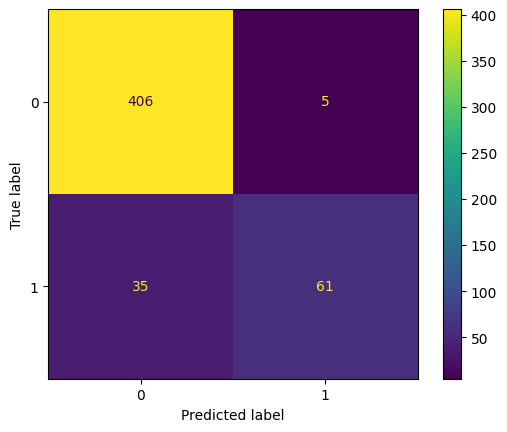

In [ ]:
# Make predictions on the test set
y_test_pred = best_clf.predict(x_test) # Predict on the unscaled x_test

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)


print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"Balanced Accuracy on the test set: {balanced_acc:.4f}")
print(f"Precision on the test set: {precision:.4f}")
print(f"Recall on the test set: {recall:.4f}")
print(f"F1-Score on the test set: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_clf.classes_)
cmd.plot()
plt.show()


Importance feature in predicting churned users:
                                Feature  Importance
6                        CashbackAmount    0.199399
0                            CustomerID    0.121507
4                       NumberOfAddress    0.105240
5                              Complain    0.087178
3                     SatisfactionScore    0.079911
2              NumberOfDeviceRegistered    0.068458
1                              CityTier    0.039743
15                          Gender_Male    0.035172
22                 MaritalStatus_Single    0.035024
17  PreferedOrderCat_Laptop & Accessory    0.026309



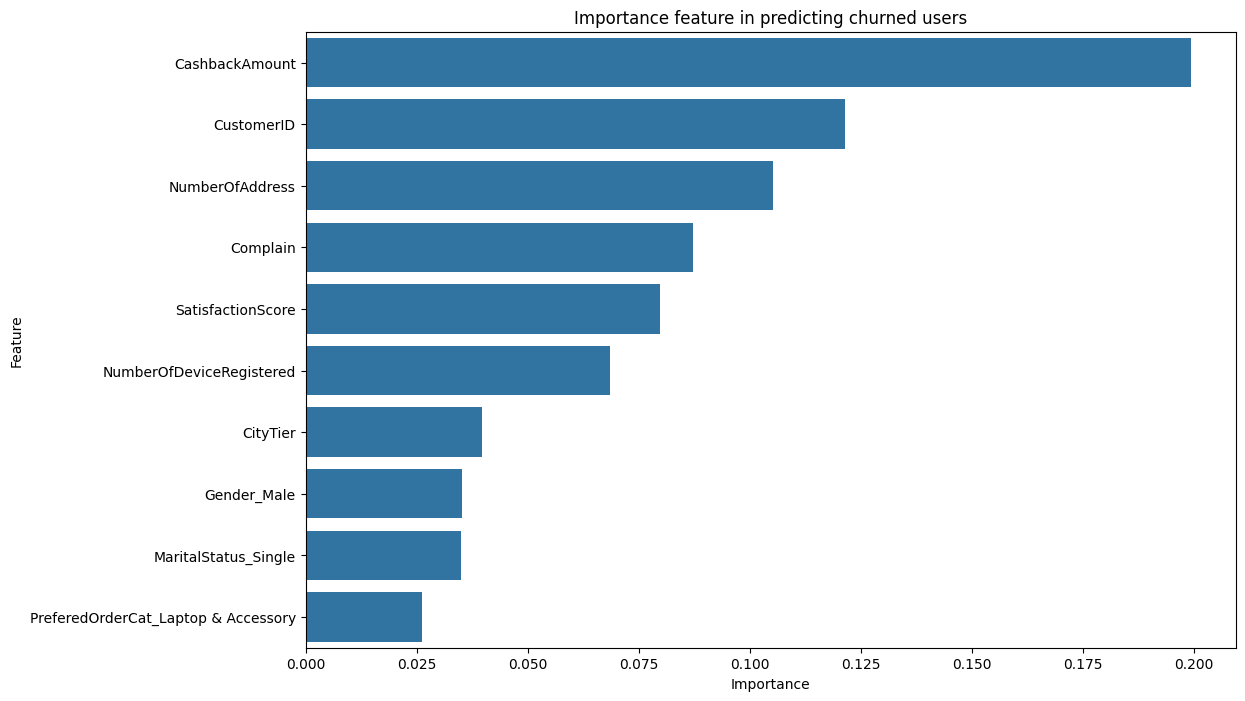

In [ ]:
# Lấy importance feature
feature_importances_supervised = best_clf.feature_importances_

# Lấy tên các feature
# Lưu ý: Tên các feature phải khớp với thứ tự trong dữ liệu huấn luyện
feature_names = x_train.columns

# Tạo một DataFrame để dễ dàng xem và sắp xếp
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_supervised})

# Sắp xếp DataFrame theo tầm quan trọng giảm dần
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Hiển thị các feature quan trọng nhất (ví dụ: top 10)
print("Importance feature in predicting churned users:")
print(importance_df.head(10))

print("")

# Biểu đồ tầm quan trọng của các feature
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Importance feature in predicting churned users')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Dựa theo những thông tin trên và biểu đồ, chúng ta có thể thấy feature ảnh hưởng đến việc tăng số lượng churned user là CashbackAmount. Ngoài ra chỉ số về Complain và SatisfactionScore cũng cần phải chú ý.

Để có thể giảm thiểu số lượng churned user thì chúng ta cần có những thêm những ưu đãi về CashbackAmount (như là tăng số lượng cash back cho người dùng mới và những người dùng lâu dài, hoặc có thể làm việc thêm với nhà cung cấp để có giá bán cho người dùng tốt hơn).

Ngoài ra đội ngũ chăm sóc khách hàng cũng cần kết hợp với những bên liên quan để giải quyết những phàn nàn từ người dùng. Phân loại những phàn nàn theo danh mục (phàn nàn về ứng dụng/trang web bị chậm, hoặc giao diện người dùng hay thời gian giao hàng, chất lượng hàng hóa khi xuất kho...). Việc xử lý tốt những phàn nàn đó cũng có thể giúp cho satisfaction score được kéo lên.

# Unsupervised learning model

## Feature engineering

### Encoding

In [ ]:
data_unsupervised_churn = data_unsupervised[data_unsupervised['Churn']==1]

In [ ]:
# in ra danh sách các cột và số lượng những giá trị có data type là string
category_cols = data_unsupervised_churn.select_dtypes(include = ['object'])
for col in category_cols:
  print(f"{col}:{data_unsupervised_churn[col].nunique()}")

PreferredLoginDevice:3
PreferredPaymentMode:7
Gender:2
PreferedOrderCat:6
MaritalStatus:3


In [ ]:
# encode các cột PreferredLoginDevice, PreferredPaymentMode, Gender, PreferedOrderCat, MaritalStatus
list_columns = ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus']
data_unsupervised_churn_encoded = pd.get_dummies(data_unsupervised_churn, columns = list_columns, drop_first=True)

data_unsupervised_churn_encoded.head()

,CustomerID,Churn,CityTier,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount,Cluster,PreferredLoginDevice_Mobile Phone,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
7,53583,1,1,5,4,3,1,143.59,1,False,...,False,False,False,False,False,False,True,False,False,True
24,55053,1,1,5,4,3,1,143.59,1,False,...,False,False,False,False,False,False,True,False,False,True
40,50768,1,1,4,4,2,1,118.59,1,False,...,False,False,False,False,False,False,True,False,False,True
58,52238,1,1,4,4,2,1,118.59,1,False,...,False,False,False,False,False,False,True,False,False,True
68,52834,1,1,6,3,3,1,185.74,0,False,...,False,False,True,False,True,False,False,False,False,True


## Model training

### Normalization data set

In [ ]:
scaler_unsupervised = MinMaxScaler()

data_unsupervised_churn_scaled = scaler_unsupervised.fit_transform(data_unsupervised_churn_encoded)


### K-Means Clustering (Unsupervised learning)

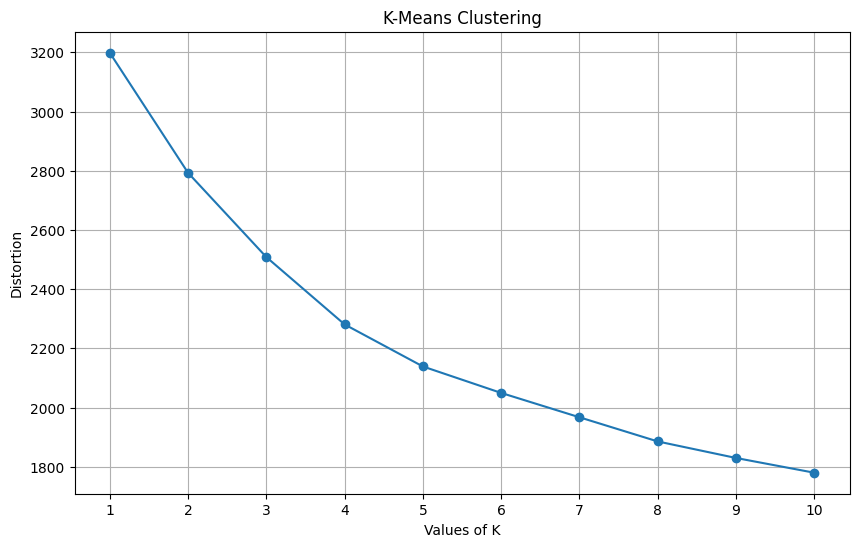

In [ ]:
# ## 1. Tìm số cụm tối ưu (Sử dụng phương pháp Elbow)
# Tạo danh sách để lưu trữ Inertia (Sum of squared distances of samples to their closest cluster center)
inertia = []

# Thử nghiệm với số lượng cụm từ 1 đến 10 (bạn có thể điều chỉnh phạm vi này)
k_range = range(1, 11)

for k in k_range:
    # Khởi tạo mô hình KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Huấn luyện mô hình trên dữ liệu đã scale
    kmeans.fit(data_unsupervised_churn_scaled)

    # Lưu giá trị Inertia
    inertia.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('K-Means Clustering')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# ## 2. Huấn luyện model K-Means với số cụm tối ưu
# Dựa vào biểu đồ Elbow, chọn số cụm tối ưu.
# Thay thế 'k_means_clustering' bằng số lượng cụm bạn chọn.
k_means_clustering = 4
# Khởi tạo model K-Means với số cụm tối ưu
kmeans_final = KMeans(n_clusters=k_means_clustering, random_state=42, n_init=10)

# Huấn luyện model trên dữ liệu đã scale
kmeans_final.fit(data_unsupervised_churn_scaled)

# ## 3. Gán cluster_label vào DataFrame gốc
# Lấy cluster_label từ model đã huấn luyện
cluster_labels_churn = kmeans_final.labels_

# Thêm cột nhãn cụm vào DataFrame dữ liệu churn đã scale
# Lưu ý: data_unsupervised_churn_scaled đang ở dạng NumPy array sau khi scale
# Chúng ta cần chuyển nó lại thành DataFrame hoặc gán nhãn vào DataFrame gốc/encoding
data_unsupervised_churn_encoded_with_clusters = data_unsupervised_churn_encoded.copy()
data_unsupervised_churn_encoded_with_clusters['Cluster'] = cluster_labels_churn

# Hiển thị các cụm và số lượng điểm trong mỗi cụm
print("\nSố lượng người dùng churn trong mỗi cụm:")
print(data_unsupervised_churn_encoded_with_clusters['Cluster'].value_counts())

# Hiển thị các cụm trong DataFrame dữ liệu churn (đã encoding)
print("\nDataFrame dữ liệu churn (đã encoding) với nhãn cụm:")
print(data_unsupervised_churn_encoded_with_clusters.head(10))


Số lượng người dùng churn trong mỗi cụm:
Cluster
3    325
0    241
2    221
1    161
Name: count, dtype: int64

DataFrame dữ liệu churn (đã encoding) với nhãn cụm:
    CustomerID  Churn  CityTier  NumberOfDeviceRegistered  SatisfactionScore  \
7        53583      1         1                         5                  4   
24       55053      1         1                         5                  4   
40       50768      1         1                         4                  4   
58       52238      1         1                         4                  4   
68       52834      1         1                         6                  3   
78       53347      1         1                         4                  2   
79       53391      1         1                         4                  3   
80       53416      1         1                         5                  4   
83       53877      1         3                         4                  1   
84       54023      1         1    

## Model evaluation

In [ ]:
# Tính toán Silhouette Score
silhouette_avg = silhouette_score(data_unsupervised_churn_scaled, cluster_labels_churn)

print(f"Average Silhouette score: {silhouette_avg:.4f}")

Average Silhouette score: 0.1589


In [ ]:
# Gộp dat_unsupervised với 'Cluster'
data_unsupervised_with_clusters = data_unsupervised_churn_encoded.copy()
data_unsupervised_with_clusters['Cluster'] = cluster_labels_churn

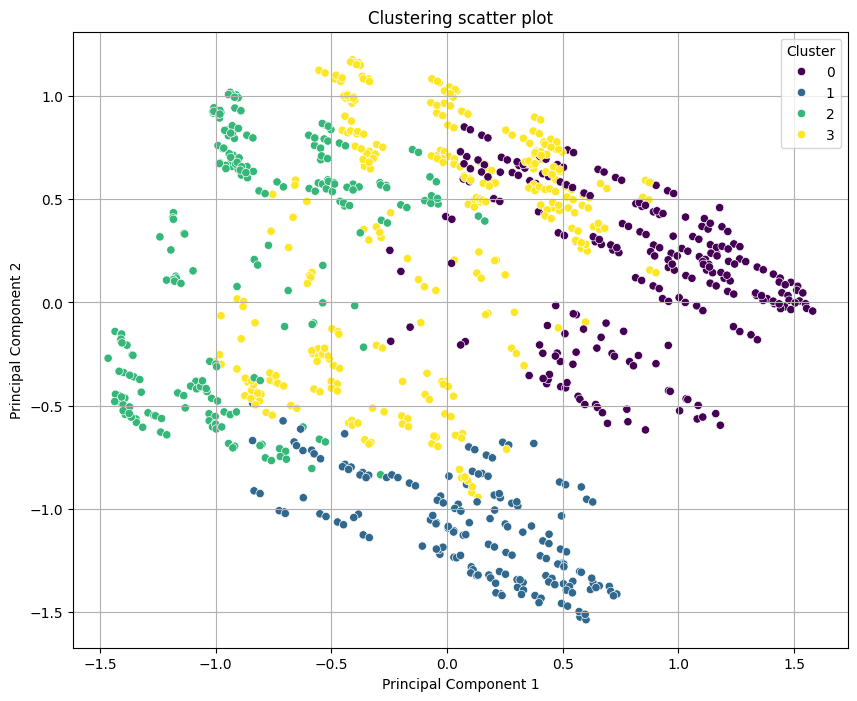

In [ ]:
# Sử dụng dữ liệu đã scale nhưng không có cột 'Cluster'
pca = PCA(n_components=2)
PCA_data = pca.fit_transform(data_unsupervised_churn_scaled)

# Tạo DataFrame từ kết quả PCA để dễ dàng vẽ biểu đồ
PCA_df = pd.DataFrame(data=PCA_data, columns=['Principal_Component_1', 'Principal_Component_2'])

# Thêm nhãn cụm vào DataFrame PCA
PCA_df['Cluster'] = cluster_labels_churn

# Vẽ biểu đồ phân tán
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Principal_Component_1', y='Principal_Component_2', hue='Cluster', data=PCA_df, palette='viridis', legend='full')
plt.title('Clustering scatter plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
# Phân tích đặc điểm của từng cụm trong nhóm churned users
print("Churned user - mean:")
print(data_unsupervised_churn_encoded_with_clusters.groupby('Cluster').agg('mean'))
print("")
print("Churned user - median")
print(data_unsupervised_churn_encoded_with_clusters.groupby('Cluster').agg('median'))
print("")
print("Churned user - count:")
print(data_unsupervised_churn_encoded_with_clusters.groupby('Cluster').agg('count'))
print("")
print("Churned user - std:")
print(data_unsupervised_churn_encoded_with_clusters.groupby('Cluster').agg('std'))

Churned user - mean:
           CustomerID  Churn  CityTier  NumberOfDeviceRegistered  \
Cluster                                                            
0        52548.921162    1.0  2.443983                  3.925311   
1        53212.099379    1.0  2.217391                  4.006211   
2        51339.049774    1.0  1.479638                  3.438914   
3        53619.649231    1.0  1.412308                  4.243077   

         SatisfactionScore  NumberOfAddress  Complain  CashbackAmount  \
Cluster                                                                 
0                 3.435685         4.958506  0.560166      190.140664   
1                 3.285714         5.161491  0.329193      189.852547   
2                 3.425339         3.570136  0.610860      125.925339   
3                 3.384615         4.366154  0.569231      147.113785   

         PreferredLoginDevice_Mobile Phone  PreferredLoginDevice_Phone  ...  \
Cluster                                             

## Apply the Random Forest model with cluster label

In [ ]:
data_unsupervised_churn_encoded_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, 7 to 5596
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CustomerID                             948 non-null    int64  
 1   Churn                                  948 non-null    int64  
 2   CityTier                               948 non-null    int64  
 3   NumberOfDeviceRegistered               948 non-null    int64  
 4   SatisfactionScore                      948 non-null    int64  
 5   NumberOfAddress                        948 non-null    int64  
 6   Complain                               948 non-null    int64  
 7   CashbackAmount                         948 non-null    float64
 8   Cluster                                948 non-null    int32  
 9   PreferredLoginDevice_Mobile Phone      948 non-null    bool   
 10  PreferredLoginDevice_Phone             948 non-null    bool   
 11  PreferredP

### Model training

Split train/ validate/ test set

In [ ]:
# bỏ cột 'Cluster'
x = data_unsupervised_churn_encoded_with_clusters.drop('Cluster', axis=1)
# tạo dataframe y với cột tên là 'Cluster'
y = data_unsupervised_churn_encoded_with_clusters[['Cluster']]

# chia dataset thành training và temp, với 30% thuộc về temp và 70% thuộc về train
x_train_un, x_temp_un, y_train_un, y_temp_un = train_test_split(x, y, test_size=0.3, random_state=42)

# chia temp thành validate và test, với 30% thuộc về test và 70% thuộc về validate
x_val_un, x_test_un, y_val_un, y_test_un = train_test_split(x_temp, y_temp, test_size=0.3, random_state=42)

print(f'Number data of train set: {len(x_train_un)}')
print(f'Number data of validate set: {len(x_val_un)}')
print(f'Number data of test set: {len(x_test_un)}')

Number data of train set: 663
Number data of validate set: 199
Number data of test set: 86


Normalizaztion data set

In [ ]:
# gọi MinMaxScaler
scaler_unsupervised_churn = MinMaxScaler()

# Áp dụng MinMaxScaler trên 3 set train, validate và test
x_train_scaled_un = scaler_unsupervised_churn.fit_transform(x_train_un)
x_val_scaled_un = scaler_unsupervised_churn.transform(x_val_un)
x_test_scaled_un = scaler_unsupervised_churn.transform(x_test_un)

# Áp dụng MinMaxScaler trên DataFrame
data_unsupervised_churn_encoded_with_clusters_scaled = scaler_unsupervised_churn.fit_transform(data_unsupervised_churn_encoded_with_clusters)
data_unsupervised_churn_encoded_with_clusters_scaled = pd.DataFrame(data_unsupervised_churn_encoded_with_clusters_scaled, columns=data_unsupervised_churn_encoded_with_clusters.columns)

data_unsupervised_churn_encoded_with_clusters_scaled.head()


,CustomerID,Churn,CityTier,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount,Cluster,PreferredLoginDevice_Mobile Phone,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,0.637253,0.0,0.0,0.8,0.75,0.105263,1.0,0.156909,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.898772,0.0,0.0,0.8,0.75,0.105263,1.0,0.156909,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.136453,0.0,0.0,0.6,0.75,0.052632,1.0,0.039813,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.397972,0.0,0.0,0.6,0.75,0.052632,1.0,0.039813,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.504003,0.0,0.0,1.0,0.50,0.105263,1.0,0.354333,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Random forest

In [ ]:
clf_rand_un = RandomForestClassifier(max_depth=15, random_state=42, n_estimators=100)

clf_rand_un.fit(x_train_scaled_un, y_train_un)

y_ranf_pre_train_un = clf_rand_un.predict(x_train_scaled_un)
y_ranf_pre_val_un = clf_rand_un.predict(x_val_scaled_un)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Model evaluation

In [ ]:
# Xác định các params để GridSearch chạy qua thử (nếu code chạy lâu quá, có thể giảm bớt số lượng params lại)
param_grid_un = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
# Ở đây mình dùng scoring là balanced_accuracy, mọi người có thể tùy chỉnh tùy vào mục đích model của mn nhé
grid_search_un = GridSearchCV(clf_rand_un, param_grid_un, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search_un.fit(x_train_un, y_train_un)

# Print the best parameters
print("Best Parameters: ", grid_search_un.best_params_)

# Evaluate the best model on the test set
best_clf_un = grid_search_un.best_estimator_
accuracy_un = best_clf_un.score(x_test_un, y_test_un)
print("Test set accuracy: ", accuracy_un)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Parameters:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test set accuracy:  1.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy on the test set: 1.0000
Balanced Accuracy on the test set: 1.0000
Precision on the test set: 1.0000
Recall on the test set: 1.0000
F1-Score on the test set: 1.0000
Confusion Matrix:
[[406   5]
 [ 35  61]]


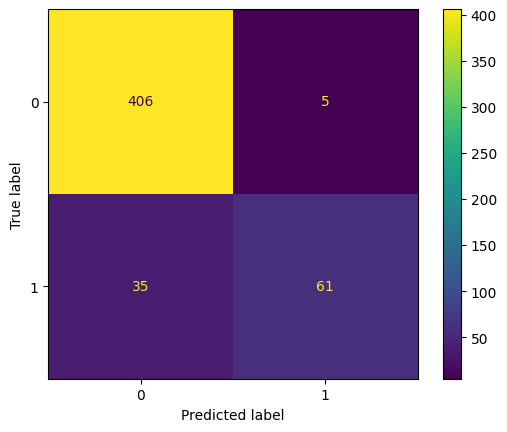

In [ ]:
# Make predictions on the test set
y_test_pred_un = best_clf_un.predict(x_test_un) # Predict on the unscaled x_test

# Calculate classification metrics
accuracy_un = accuracy_score(y_test_un, y_test_pred_un)
balanced_acc_un = balanced_accuracy_score(y_test_un, y_test_pred_un)
precision_un = precision_score(y_test_un, y_test_pred_un, average='weighted')
recall_un = recall_score(y_test_un, y_test_pred_un, average='weighted')
f1_un = f1_score(y_test_un, y_test_pred_un, average='weighted')
conf_matrix_un = confusion_matrix(y_test_un, y_test_pred_un)


print(f"Accuracy on the test set: {accuracy_un:.4f}")
print(f"Balanced Accuracy on the test set: {balanced_acc_un:.4f}")
print(f"Precision on the test set: {precision_un:.4f}")
print(f"Recall on the test set: {recall_un:.4f}")
print(f"F1-Score on the test set: {f1_un:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_clf.classes_)
cmd.plot()
plt.show()


Importance feature in predicting churned users:
                                Feature  Importance
20        PreferedOrderCat_Mobile Phone    0.190272
7                        CashbackAmount    0.181011
19              PreferedOrderCat_Mobile    0.155356
22                MaritalStatus_Married    0.142765
18  PreferedOrderCat_Laptop & Accessory    0.064108
0                            CustomerID    0.060980
23                 MaritalStatus_Single    0.042413
8     PreferredLoginDevice_Mobile Phone    0.029393
2                              CityTier    0.023698
9            PreferredLoginDevice_Phone    0.022767



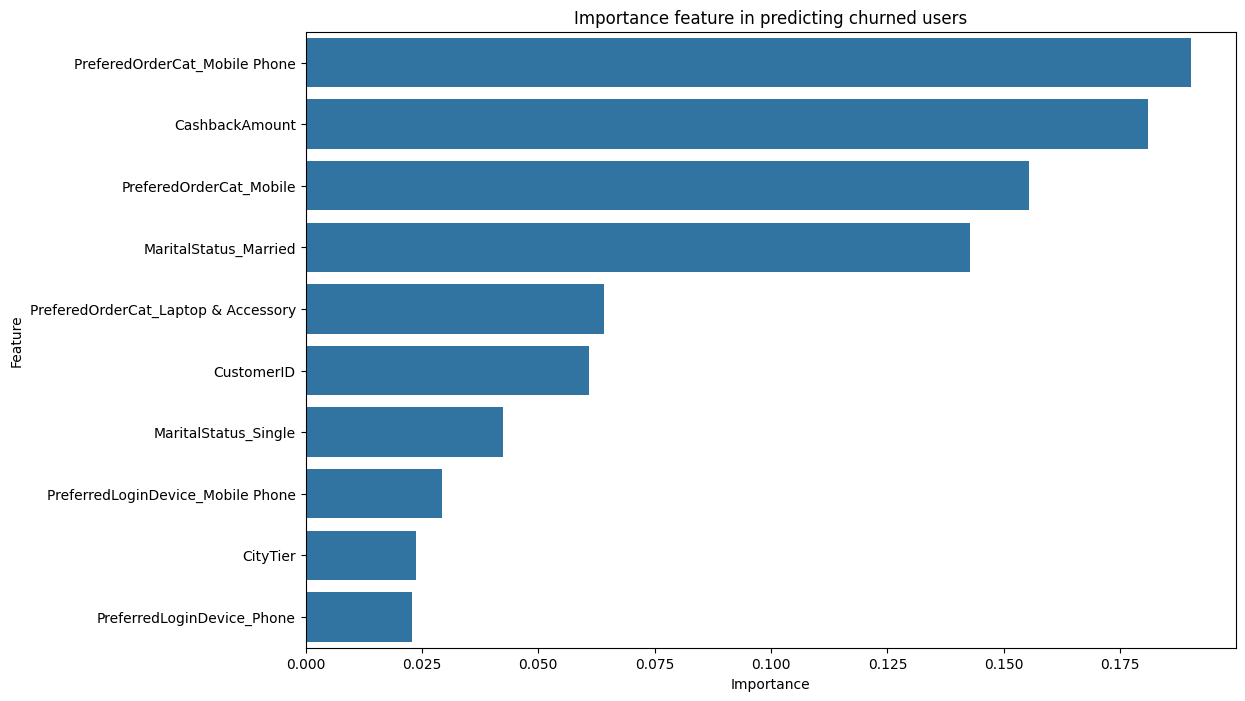

In [ ]:
# Lấy importance features
feature_importances_unsupervised = best_clf_un.feature_importances_

# Lấy tên các feature
# Lưu ý: Tên các feature phải khớp với thứ tự trong dữ liệu huấn luyện
feature_names_un = x_train.columns

# Tạo một DataFrame để dễ dàng xem và sắp xếp
importance_df_un = pd.DataFrame({'Feature': feature_names_un, 'Importance': feature_importances_unsupervised})

# Sắp xếp DataFrame theo tầm quan trọng giảm dần
importance_df_un = importance_df_un.sort_values(by='Importance', ascending=False)

# Hiển thị các feature quan trọng nhất (ví dụ: top 10)
print("Importance feature in predicting churned users:")
print(importance_df_un.head(10))

print("")

# Biểu đồ tầm quan trọng của các feature
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_un.head(10))
plt.title('Importance feature in predicting churned users')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Theo như barplot trên: PreferedOrderCat_Mobile Phone, CashbackAmount, PreferedOrderCat_Mobile là 3 feature mà các nhóm churned user khác nhau.